# Clustering Crypto

In [75]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [76]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [77]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [78]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")
from pathlib import Path
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_data = pd.read_csv(file_path, index_col=0)
crypto_data[:5], crypto_data.dtypes, crypto_data.shape

(      CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
 42     42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
 365    365Coin       X11       True   PoW/PoS              NaN      2300000000
 404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
 611  SixEleven   SHA-256       True       PoW              NaN          611000
 808        808   SHA-256       True   PoW/PoS     0.000000e+00               0,
 CoinName            object
 Algorithm           object
 IsTrading             bool
 ProofType           object
 TotalCoinsMined    float64
 TotalCoinSupply     object
 dtype: object,
 (1252, 6))

### Data Preprocessing

In [79]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df = crypto_data[['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']]

In [80]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df["IsTrading"] == True]
crypto_df[:5], crypto_df.shape

(      CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
 42     42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
 365    365Coin       X11       True   PoW/PoS              NaN      2300000000
 404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
 611  SixEleven   SHA-256       True       PoW              NaN          611000
 808        808   SHA-256       True   PoW/PoS     0.000000e+00               0,
 (1144, 6))

In [81]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df["Algorithm"] !="N/A"]
crypto_df[:5], crypto_df.shape

(      CoinName Algorithm  IsTrading ProofType  TotalCoinsMined TotalCoinSupply
 42     42 Coin    Scrypt       True   PoW/PoS     4.199995e+01              42
 365    365Coin       X11       True   PoW/PoS              NaN      2300000000
 404    404Coin    Scrypt       True   PoW/PoS     1.055185e+09       532000000
 611  SixEleven   SHA-256       True       PoW              NaN          611000
 808        808   SHA-256       True   PoW/PoS     0.000000e+00               0,
 (1144, 6))

In [82]:
# Remove the "IsTrading" column
crypto_df.drop("IsTrading", axis=1, inplace=True)
crypto_df[:5], crypto_df.shape

(      CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
 42     42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
 365    365Coin       X11   PoW/PoS              NaN      2300000000
 404    404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
 611  SixEleven   SHA-256       PoW              NaN          611000
 808        808   SHA-256   PoW/PoS     0.000000e+00               0,
 (1144, 5))

In [83]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna(axis=0, how="any")
crypto_df[:5], crypto_df.shape

(       CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
 42      42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
 404     404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
 808         808   SHA-256   PoW/PoS     0.000000e+00               0
 1337  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
 BTC     Bitcoin   SHA-256       PoW     1.792718e+07        21000000,
 (685, 5))

In [84]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"] >0]
crypto_df[:5], crypto_df.shape

(       CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
 42      42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
 404     404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
 1337  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
 BTC     Bitcoin   SHA-256       PoW     1.792718e+07        21000000
 ETH    Ethereum    Ethash       PoW     1.076842e+08               0,
 (532, 5))

In [85]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df[:] != "N/A"]
crypto_df[:5], crypto_df.shape

(       CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
 42      42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
 404     404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
 1337  EliteCoin       X13   PoW/PoS     2.927942e+10    314159265359
 BTC     Bitcoin   SHA-256       PoW     1.792718e+07        21000000
 ETH    Ethereum    Ethash       PoW     1.076842e+08               0,
 (532, 5))

In [86]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name = pd.DataFrame(crypto_df["CoinName"], index=crypto_df.index)
coins_name[:5]

,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [87]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop("CoinName", axis=1)
crypto_df[:5]

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [88]:
# Create dummy variables for text features
X = pd.get_dummies(data=crypto_df, columns=["Algorithm", "ProofType"])
X[:5]

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Standardize data
X = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [90]:
# Use PCA to reduce dimensions to 3 principal components
n_comp = 3
pca = PCA(n_components=n_comp)
principal_components = pca.fit_transform(X)
principal_components

array([[-0.34064882,  1.0022938 , -0.56730197],
       [-0.32396595,  1.00256829, -0.56772867],
       [ 2.31032365,  1.5723774 , -0.65813696],
       ...,
       [ 0.33439705, -2.27934245,  0.4126176 ],
       [-0.14415657, -1.98777725,  0.33464537],
       [-0.29736153,  0.81460542, -0.26959702]])

In [91]:
# Create a DataFrame with the principal components data
col_names = [f"PC {i}" for i in range(1, n_comp + 1)]
pcs_df = pd.DataFrame(principal_components, columns=col_names, index = crypto_df.index)
pcs_df[:5]

,PC 1,PC 2,PC 3
42,-0.340649,1.002294,-0.567302
404,-0.323966,1.002568,-0.567729
1337,2.310324,1.572377,-0.658137
BTC,-0.143295,-1.352593,0.206254
ETH,-0.147000,-2.019306,0.392550


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [92]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=5`

In [93]:
# Initialize the K-Means model
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, pcs_df], axis=1, sort=False)
clustered_df["CoinName"] = coins_name["CoinName"]
clustered_df["Class"] = model.labels_
clustered_df[:5]

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,Class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.340649,1.002294,-0.567302,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.323966,1.002568,-0.567729,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.310324,1.572377,-0.658137,EliteCoin,4
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.143295,-1.352593,0.206254,Bitcoin,1
ETH,Ethash,PoW,1.076842e+08,0,-0.147000,-2.019306,0.392550,Ethereum,1


### Visualizing Results

#### 3D-Scatter with Clusters

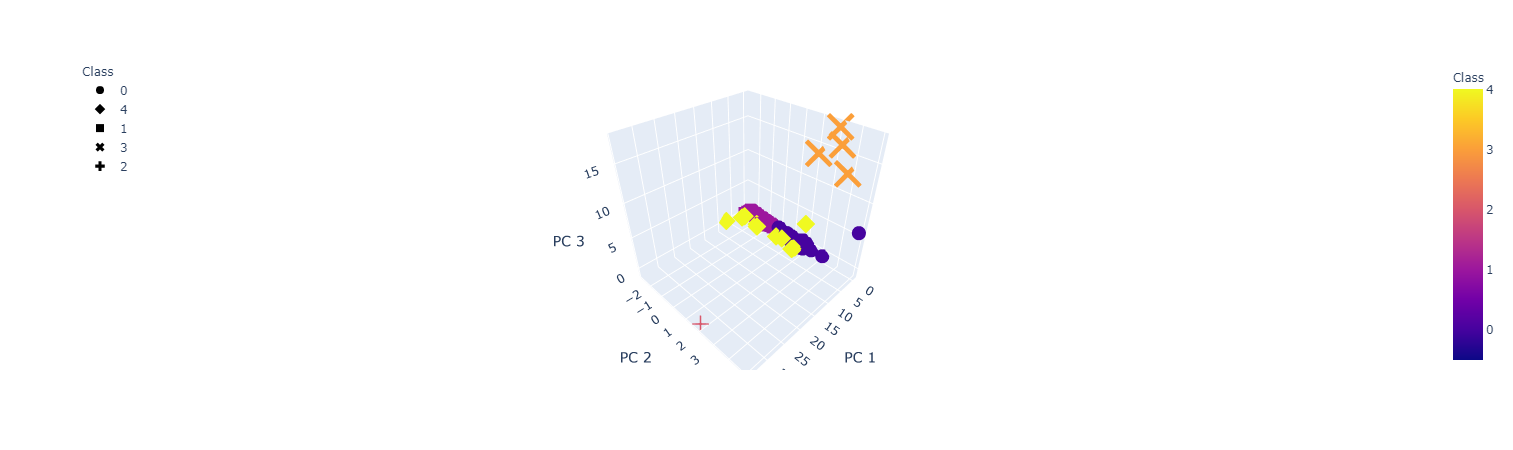

In [94]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [95]:
# Table with tradable cryptos
clustered_df[
    [
        "CoinName",
        "Algorithm",
        "ProofType",
        "TotalCoinSupply",
        "TotalCoinsMined",
        "Class",
    ]
].hvplot.table()

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [96]:
# Print the total number of tradable cryptocurrencies
len(clustered_df['CoinName'])

532

#### Scatter Plot with Tradable Cryptocurrencies

In [97]:
# Scale data to create the scatter plot
mm_scaler = MinMaxScaler()
plot_data = mm_scaler.fit_transform(
    clustered_df[["TotalCoinSupply", "TotalCoinsMined"]]
)
plot_df = pd.DataFrame(
    plot_data, columns=["TotalCoinSupply", "TotalCoinsMined"], index=clustered_df.index
)
plot_df["CoinName"] = clustered_df["CoinName"]
plot_df["Class"] = clustered_df["Class"]
plot_df[:5]

,TotalCoinSupply,TotalCoinsMined,CoinName,Class
42,4.200000e-11,0.000000,42 Coin,0
404,5.320000e-04,0.001066,404Coin,0
1337,3.141593e-01,0.029576,EliteCoin,4
BTC,2.100000e-05,0.000018,Bitcoin,1
ETH,0.000000e+00,0.000109,Ethereum,1


In [98]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
plot_df.hvplot.scatter(
    x="TotalCoinsMined", y="TotalCoinSupply", hover_cols=["CoinName"], by="Class"
)

:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)